## 下载最新的dataset.csv

In [1]:
sheet_id = "13Q7OtTh50BKiHMxa_t0g0Yz44VcEeRlhvlmSOoGUPGw"
gid = "1221129144"
!curl -L "https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}" -o ./metadata.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   431    0   431    0     0    822      0 --:--:-- --:--:-- --:--:--   824
100  139k    0  139k    0     0   121k      0 --:--:--  0:00:01 --:--:--  404k


## 倒入pakage 并且define 函数

In [2]:
import numpy as np
import tensorflow_datasets as tfds
from PIL import Image
from IPython import display
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf
from tqdm import tqdm
from matplotlib import font_manager as fm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import pprint

nlp = spacy.load("en_core_web_sm")
font_path = "/home2/qrchen/GillSans.ttc"
font_prop = fm.FontProperties(fname=font_path)
MAX_TRAJECTORIES_PER_TASK = 4  # will be replaced by MAX_TASKS
def visualize_task_gifs(save_root, task_name, max_gifs=MAX_TRAJECTORIES_PER_TASK):
    """
    在Jupyter Notebook中显示指定任务的所有GIF
    
    参数:
        task_name: 要显示的任务名称
        max_gifs: 最多显示的GIF数量
    """
    task_filename = task_name.replace(" ", "_").replace(".", "")
    task_dir = os.path.join(save_root, "samples", task_filename)
    
    if not os.path.exists(task_dir):
        print(f"没有找到任务 '{task_name}' 的GIF")
        return
    
    gif_files = sorted([f for f in os.listdir(task_dir) if f.endswith('.gif')])
    if not gif_files:
        print(f"任务 '{task_name}' 没有可用的GIF")
        return
    
    print(f"显示任务 '{task_name}' 的GIF:")
    for i, gif_file in enumerate(gif_files[:max_gifs]):
        gif_path = os.path.join(task_dir, gif_file)
        print(f"轨迹 {i+1}:")
        display.display(display.Image(filename=gif_path))
        
# dataset_name is the nickname of the dataset
def dataset2path(dataset_name):
    import subprocess
    import re
    
    try:
        # 调用 gsutil ls 命令获取所有版本
        cmd = f'gsutil ls gs://gresearch/robotics/{dataset_name}/'
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        
        if result.returncode != 0:
            print(f"警告: 无法访问 gs://gresearch/robotics/{dataset_name}/，错误信息: {result.stderr}")
            # 如果失败，使用默认版本号逻辑
            if dataset_name == 'robo_net':
                default_version = '1.0.0'
            elif dataset_name in ['language_table', 'robo_set', 'spoc',"DROID"]:
                default_version = '0.0.1'
            elif dataset_name in ['droid']:
                default_version = '1.0.0'
            else:
                default_version = '0.1.0'
            print(f"使用默认版本号: {default_version}")
            return f'gs://gresearch/robotics/{dataset_name}/{default_version}'
        
        # 解析输出，查找版本号格式 数字.数字.数字 或 数字.数字
        lines = result.stdout.strip().split('\n')
        versions = []
        
        for line in lines:
            if line.strip():
                # 提取路径中的版本号部分
                # 格式: gs://gresearch/robotics/{dataset_name}/{version}/
                match = re.search(rf'gs://gresearch/robotics/{re.escape(dataset_name)}/(\d+\.\d+(?:\.\d+)?)', line)
                if match:
                    version_str = match.group(1)
                    versions.append(version_str)
        
        if not versions:
            print(f"警告: 未找到有效的版本号，使用默认版本")
            # 使用默认版本号逻辑
            if dataset_name == 'robo_net':
                backup_version = '1.0.0'
            elif dataset_name in ['language_table', 'robo_set', 'spoc',"DROID"]:
                backup_version = '0.0.1'
            elif dataset_name in ['droid']:
                backup_version = '1.0.0'
            else:
                backup_version = '0.1.0'
            print(f"使用默认版本号: {backup_version}")
            return f'gs://gresearch/robotics/{dataset_name}/{backup_version}'
        
        # 对版本号进行排序，找到最小版本
        def version_key(version_str):
            try:
                parts = version_str.split('.')
                return tuple(int(part) for part in parts)
            except ValueError:
                # 如果版本号格式有问题，返回一个很大的数字作为排序键
                return (999, 999, 999)
        
        # 去重版本号列表
        unique_versions = list(set(versions))
        min_version = min(unique_versions, key=version_key)
        print(f"数据集 {dataset_name} 找到版本: {versions}，去重后: {unique_versions}，选择最大版本: {min_version}")
        print(f'正常返回 gs://gresearch/robotics/{dataset_name}/{min_version}')
        return f'gs://gresearch/robotics/{dataset_name}/{min_version}'
        
    except Exception as e:
        print(f"错误: 获取数据集 {dataset_name} 版本时出错: {e}")
        # 出错时使用默认版本号逻辑
        if dataset_name == 'robo_net':
            fallback_version = '1.0.0'
        elif dataset_name in ['language_table', 'robo_set', 'spoc',"DROID"]:
            fallback_version = '0.0.1'
        elif dataset_name in ['droid']:
            fallback_version = '1.0.0'
        else:
            fallback_version = '0.1.0'
        print(f"使用默认版本号: {fallback_version}")
        print(f'异常 gs://gresearch/robotics/{dataset_name}/{min_version}')
        return f'gs://gresearch/robotics/{dataset_name}/{fallback_version}'

# ============ 工具函数 ============
def depth_to_color_img(depth):
    """将depth转为彩色图像"""
    d = depth.copy()
    d = (d - np.nanmin(d)) / (np.nanmax(d) - np.nanmin(d) + 1e-8)
    cm = plt.get_cmap('jet')
    colored = cm(d)[:, :, :3]  # 只要RGB，不要alpha
    colored = (colored * 255).astype(np.uint8)
    return colored

def as_gif(images, path="temp.gif", resize_factor=0.5):
    """生成GIF文件"""
    if resize_factor != 1.0:
        resized_images = []
        for img in images:
            width, height = img.size
            new_size = (int(width * resize_factor), int(height * resize_factor))
            resized_images.append(img.resize(new_size, Image.Resampling.LANCZOS))
        images = resized_images
    
    images[0].save(path, save_all=True, append_images=images[1:], duration=int(1000/10), loop=0)
    gif_bytes = open(path,"rb").read()
    return gif_bytes

def get_language_instruction(episode, config):
    """提取语言指令"""
    for step in episode["steps"]:
        lang_inst = step[config["language_field"]].numpy()
        if isinstance(lang_inst, bytes):
            lang_inst = lang_inst.decode('utf-8')
        return lang_inst
    return ""


def center_pad_images_to_max_size(images):
    """将图像列表居中对齐并填充到最大尺寸"""
    if not images:
        return images
    
    # 找到最大的高度和宽度
    max_height = max(img.shape[0] for img in images)
    max_width = max(img.shape[1] for img in images)
    
    padded_images = []
    for img in images:
        height, width = img.shape[:2]
        
        # 计算居中对齐需要的填充
        pad_height_total = max_height - height
        pad_width_total = max_width - width
        
        # 分别计算上下、左右的填充量（居中对齐）
        pad_top = pad_height_total // 2
        pad_bottom = pad_height_total - pad_top
        pad_left = pad_width_total // 2
        pad_right = pad_width_total - pad_left
        
        # 使用黑色填充 (0值)
        if len(img.shape) == 3:  # RGB图像
            padded_img = np.pad(img, 
                              ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), 
                              mode='constant', 
                              constant_values=0)
        else:  # 灰度图像
            padded_img = np.pad(img, 
                              ((pad_top, pad_bottom), (pad_left, pad_right)), 
                              mode='constant', 
                              constant_values=0)
        
        padded_images.append(padded_img)
    
    return padded_images

def process_single_step(obs, config):
    """处理单帧数据，返回拼接的图像和深度图像"""
    # 提取RGB图像
    rgb_images = []
    for field in config["image_fields"]:
        # 处理嵌套图像路径
        if isinstance(field, tuple):
            field_name, sub_field_name = field
            rgb_images.append(obs[field_name][sub_field_name].numpy())
        else:
            rgb_images.append(obs[field].numpy())
    
    # 将RGB图像居中对齐并填充到相同尺寸后拼接
    padded_rgb_images = center_pad_images_to_max_size(rgb_images)
    concat_rgb = np.concatenate(padded_rgb_images, axis=1)
    
    # 提取并处理深度图像
    depth_images = []
    if len(config["depth_fields"]) > 0:
      for field in config["depth_fields"]:
        depth_img = obs[field].numpy()
        color_depth = depth_to_color_img(depth_img)
        depth_images.append(color_depth)
      
      # 将深度图像居中对齐并填充到相同尺寸后拼接
      padded_depth_images = center_pad_images_to_max_size(depth_images)
      concat_depth = np.concatenate(padded_depth_images, axis=1)
    else:
      concat_depth = np.zeros_like(concat_rgb)
    
    return Image.fromarray(concat_rgb), Image.fromarray(concat_depth)

def process_episode(episode, episode_idx, config):
    """处理单个episode"""
    # 获取语言指令
    lang_inst = get_language_instruction(episode, config)
    if lang_inst == "":
        return None
    
    print(f"Language Instruction: {lang_inst}")
    
    # 动态调整帧抽取
    total_frames = len(list(episode['steps']))
    frame_skip = FRAME_SKIP_LARGE if total_frames > LARGE_FRAME_THRESHOLD else FRAME_SKIP_DEFAULT
    print(f"当前episode总帧数: {total_frames}, 抽取帧数: {frame_skip}")
    
    # 收集图像
    rgb_images = []
    depth_images = []
    
    for step_idx, step in enumerate(episode["steps"]):
        if step_idx % frame_skip == 0:
            obs = step[config["observation_field"]]
            rgb_img, depth_img = process_single_step(obs, config)
            rgb_images.append(rgb_img)
            # depth_images.append(depth_img)
    
    # 生成文件名
    safe_filename = lang_inst.replace(" ", "_").replace(".", "")
    rgb_path = f"{OUTPUT_DIR}/{safe_filename}_{episode_idx}_image.gif"
    depth_path = f"{OUTPUT_DIR}/{safe_filename}_{episode_idx}_depth.gif"
    
    # 保存GIF
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    display.Image(as_gif(rgb_images, rgb_path, RESIZE_FACTOR))
    # display.Image(as_gif(depth_images, depth_path, RESIZE_FACTOR))
    print(f"已生成GIF文件: {rgb_path}, {depth_path}")
    
    return {
        "total_frames": total_frames,
        "processed_frames": len(rgb_images),
        "rgb_path": rgb_path,
        "depth_path": depth_path
    }

/home/xthu/miniforge3/envs/OXEdatasets/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-29 21:40:37.272395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753796437.296835  431697 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753796437.304690  431697 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753796437.354293  431697 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more t

## 人为配置

In [3]:
df = pd.read_csv('/home2/qrchen/embodied-datasets/metadata.csv')

TRAIN_SPLIT = 'train[:200]'  
FRAME_SKIP_DEFAULT = 7
RESIZE_FACTOR = 1
MAX_EPISODES = 100
FRAME_SKIP_LARGE = 10  # 当帧数>100时使用
LARGE_FRAME_THRESHOLD = 100
THIRD_PERSON_FRAME_THRESHOLD = 1000


DATASET_CONFIG = {
    "dataset_name_in_csv": "CMU Food Manipulation",
    "language_field": "language_instruction",
    "observation_field": "observation",
    "image_fields": ["image","finger_vision_1","finger_vision_2"],
    "depth_fields": []
}  

# 从df 中找到 DATASET_CONFIG 中 dataset_name_in_csv 对应的 行，得到其中 nickname 的值
dataset_name_in_csv = DATASET_CONFIG["dataset_name_in_csv"]
dataset = df[df['Datasets'] == dataset_name_in_csv]

dataset = dataset['NickName'].item()
OUTPUT_DIR = f"Trajectories/{dataset}/sample"


## Read and build data from dataset 

In [4]:

b = tfds.builder_from_directory(builder_dir=dataset2path(dataset))
ds = b.as_dataset(split=TRAIN_SPLIT)
print("total episodes: ", len(ds))
ds = ds.take(MAX_EPISODES)
print("sample episodes: ", len(ds))


数据集 cmu_playing_with_food 找到版本: ['1.0.0', '1.0.0']，去重后: ['1.0.0']，选择最大版本: 1.0.0
正常返回 gs://gresearch/robotics/cmu_playing_with_food/1.0.0


2025-07-29 21:50:49.185495: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


total episodes:  200
sample episodes:  100


W0000 00:00:1753797054.355578  431697 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 生产GIF 图片，旧版本，先不要使用

In [ ]:
# count = 0
# print("开始读取数据...")
# for episode_idx, episode in enumerate(ds):  # type: ignore
#     print(f"\n=== Episode {episode_idx + 1} ===")
    
#     result = process_episode(episode, episode_idx, DATASET_CONFIG)
#     if result is None:
#         continue 
#     count += 1
#     if count >= 2:
#         break

## 统计数据

In [ ]:

import spacy
from collections import Counter
from tqdm import tqdm
import numpy as np
import tensorflow_datasets as tfds

# 1. 统计动词和动词短语
frame_num = []
task_list = []
# def extract_verbs_and_phrases_from_tasks(task_list):
#     """
#     从英语任务列表中提取动词和动词短语，并统计它们的出现次数。
#     """
#     nlp = spacy.load("en_core_web_sm")
#     verbs_and_phrases = []
#     for task in task_list:
#         doc = nlp(task)
#         for token in doc:
#             if token.pos_ == "VERB":
#                 verbs_and_phrases.append(token.text.lower())
#                 phrase = [token.text.lower()]
#                 for child in token.children:
#                     if child.pos_ in ["PART", "ADV"]:
#                         phrase.append(child.text.lower())
#                 if len(phrase) > 1:
#                     verbs_and_phrases.append(" ".join(phrase))
#     counts = Counter(verbs_and_phrases)
#     return dict(counts)

# 2. 统计帧数和收集instruction

def get_instructions_and_frame_stats(ds):
    task_list = []
    frame_num = []
    for episode_idx, episode in tqdm(enumerate(ds)):
        step_0 = list(episode['steps'])[0]
        if 'natural_language_instruction' in step_0['observation']:
            task = step_0['observation']['natural_language_instruction'].numpy().decode('utf-8')
        elif 'language_instruction' in step_0:
            task = step_0['language_instruction'].numpy().decode('utf-8')
        elif 'multimodal_instruction' in step_0:
            task = step_0['multimodal_instruction'].numpy().decode('utf-8')
        else:
            instruction_bytes = step_0["observation"]["instruction"]
            instruction_encoded = tf.strings.unicode_encode(instruction_bytes, output_encoding="UTF-8")
            task = tf.strings.split(instruction_encoded, "\x00")[0].numpy().decode('utf-8')
        if task == "":
            task = "dummy"
        task_list.append(task)
        frame_num.append(len(list(episode['steps'])))
    return task_list, frame_num

task_list, frame_num = get_instructions_and_frame_stats(ds)

# 3. 统计帧数均值和标准差
# 每一个episode统计帧数均值和标准差
mean_frames = np.mean(frame_num) if frame_num else 0
std_frames = np.std(frame_num) if frame_num else 0
print("--------------------------------")
print(f"Mean frames per episode: {mean_frames:.2f}")
print(f"Standard deviation of frames: {std_frames:.2f}")
print(f"总episode数: {len(frame_num)}，总instruction数: {len(task_list)}，去重后instruction数: {len(set(task_list))}")
# 统计动词和动词短语
# verb_stats = extract_verbs_and_phrases_from_tasks(task_list)
# print("动词和动词短语统计:")
# for k, v in sorted(verb_stats.items(), key=lambda x: -x[1]):
#     print(f"{k}: {v}")
# print(f"总动词和动词短语数: {len(verb_stats)}")
print("--------------------------------")
print(f"所有instruction的数量:{len(task_list)}")
print(f"所有的instruction: {task_list}")
print(f"所有的instruction去重后数: {len(set(task_list))}")
print(f"所有的instruction去重后:")
for index,i in enumerate(set(task_list)):
    print(f"{index+1}.{i}")
print(Counter(task_list))

0it [00:00, ?it/s]2025-07-29 21:51:02.085618: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-29 21:55:00.882567: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-29 21:55:00.963461: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
1it [03:58, 238.90s/it]2025-07-29 21:56:33.042159: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
3it [07:02, 124.64s/it]2025-07-29 21:58:04.631755: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
7it [07:03, 21.56s/it] 2025-07-29 21:58:13.948875: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting w

--------------------------------
Mean frames per episode: 127.39
Standard deviation of frames: 17.74
总episode数: 100，总instruction数: 100，去重后instruction数: 61
--------------------------------
所有instruction的数量:100
所有的instruction: ['Grasp the carrot slice.', 'Release the tomato slice.', 'Release the raw_steak slice.', 'Press down on the boiled_pear slice.', 'Release the boiled_apple slice.', 'Grasp the mozzarella slice.', 'Release the banana slice.', 'Grasp the boiled_carrot slice.', 'Release the boiled_jalapeno slice.', 'Grasp the cheddar slice.', 'Grasp the banana slice.', 'Press down on the bell_pepper slice.', 'Press down on the onion slice.', 'Grasp the tomato slice.', 'Grasp the boiled_carrot slice.', 'Release the boiled_celery slice.', 'Press down on the jalapeno slice.', 'Press down on the raw_steak slice.', 'Grasp the celery slice.', 'Release the cheddar slice.', 'Grasp the tomato slice.', 'Press down on the bread slice.', 'Press down on the banana slice.', 'Grasp the spam slice.', 

In [1]:
file_name = f'xthLog/{dataset}.txt'
os.makedirs(os.path.dirname(file_name), exist_ok=True)
with open(file_name, 'w') as f:
    for index ,i in enumerate(set(task_list)):
        f.write(f'{index+1}.{i}\n')

NameError: name 'dataset' is not defined

## 按照MAX_TASKS 个task 生成 gif 图片，并且保存在对应的samples/路径下

In [44]:
from collections import defaultdict
from PIL import Image
from PIL.ImageQt import rgb 
save_root = f"/home2/qrchen/embodied-datasets/Trajectories/{dataset}"
os.makedirs(os.path.join(save_root, "samples"), exist_ok=True)


frame_skip = 2

# 每个task 最多的 trajectory 数
MAX_TRAJECTORIES_PER_TASK = 4
# 最多生成多少个task，如果一共有100 个task，那么我们只会输出 MAX_TASKS 个task
MAX_TASKS = 10





# 1. 统计每个任务的轨迹数
file_name_list = [] # 每个task 的 trajectory 数

task_counters = defaultdict(list) # 每个task 的 trajectory 数
task_counters.clear()
for key in Counter(task_list):
    if len(key):
        task_counters[key]


# 2. 遍历每个轨迹，统计每个任务的轨迹数
for episode_idx, episode in tqdm(enumerate(ds)):

    # 2.1 如果任务数超过最大任务数，则跳过
    if sum(1 for lst in task_counters.values() if len(lst) > 0) > MAX_TASKS:
        break

    task = ''
    step_0 = list(episode['steps'])[0]# 获取轨迹的第一个step
    # 2.2 获取任务 遍历 嵌套字典
    if 'natural_language_instruction' in step_0['observation']: 
        task = step_0['observation']['natural_language_instruction'].numpy().decode('utf-8')
    elif 'language_instruction' in step_0:
        task = step_0['language_instruction'].numpy().decode('utf-8')
    elif 'multimodal_instruction' in step_0:
        task = step_0['multimodal_instruction'].numpy().decode('utf-8')
    else:
        instruction_bytes = step_0["observation"]["instruction"]
        instruction_encoded = tf.strings.unicode_encode(instruction_bytes, output_encoding="UTF-8")
        task = tf.strings.split(instruction_encoded, "\x00")[0].numpy().decode('utf-8')

    # 2.3 如果任务为空，则跳过  
    if not len(task):
        task = "dummy"


    # 2.4 如果任务数超过最大任务数，则跳过
    if task in task_counters and len(task_counters[task]) >= MAX_TRAJECTORIES_PER_TASK:
        continue
    

    rgb_images = []
    for step_index ,step in enumerate(episode['steps']):
        if step_index % frame_skip == 0:
            obs = step[DATASET_CONFIG["observation_field"]]
            rgb_img, depth_img = process_single_step(obs, DATASET_CONFIG)
            rgb_images.append(rgb_img)


    if task not in task_counters or len(task_counters[task]) < MAX_TRAJECTORIES_PER_TASK:
        # 如果task 的长度过长了，那么需要进行截断
        if len(task) > 200:
            task = task[:200]
        if rgb_images:
            task_filename = task.replace(" ", "_").replace(".", "")
            
            current_count = len(task_counters[task])
            gif_path= os.path.join(save_root, "samples", task_filename, f"{current_count}.gif")
            os.makedirs(os.path.dirname(gif_path), exist_ok=True)
            task_counters[task].append(f"{current_count}.gif")
            display.Image(as_gif(rgb_images, gif_path, RESIZE_FACTOR))


task_counters

0it [00:00, ?it/s]

18it [02:25,  8.10s/it]


defaultdict(list,
            {'Press the stapler.': ['0.gif'],
             'Open the drawer.': ['0.gif'],
             'Pick up the object under the table and put it on top of the table.': ['0.gif'],
             'Disassemble the object': ['0.gif', '1.gif', '2.gif', '3.gif'],
             'Close Water kettle .': ['0.gif', '1.gif'],
             'Push the cube to the goal location represented using a cross.': ['0.gif',
              '1.gif',
              '2.gif'],
             'Stack cups together.': ['0.gif', '1.gif'],
             'Pick up the brush and put it on the table.': ['0.gif'],
             'Pick up the brush and sweep the table.': ['0.gif'],
             'Close the laptop.': ['0.gif'],
             'Pick up the object and place it in the box.': ['0.gif'],
             'Separate the stacked cups..': [],
             'Pick up the screw driver and place it in the box.': [],
             'Pick up the object on the table and place it in the cup.': [],
             'Pick up the

显示任务 'Pick up the object under the table and put it on top of the table.' 的GIF:
轨迹 1:


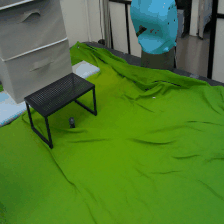

In [45]:
visualize_task_gifs(save_root, list(task_counters.keys())[2]) # 显示第一个任务的GIF

## Modify javascript

In [59]:
from jinja2 import Template


with open('/home2/qrchen/embodied-datasets/Templates/script.js', 'r', encoding='utf-8') as f:
    js_template = Template(f.read())

filled_js = js_template.render(
    gif_paths=pprint.pformat(dict(task_counters))
)

with open(os.path.join(save_root, 'script.js'), 'w', encoding='utf-8') as f:
    f.write(filled_js)

## Modify html

In [57]:
import pandas as pd
df = pd.read_csv('/home2/qrchen/embodied-datasets/metadata.csv')

with open("/home2/qrchen/embodied-datasets/Templates/index.html", "r", encoding="utf-8") as f:
    html_content = f.read()

dataset_name_in_csv = DATASET_CONFIG["dataset_name_in_csv"]
metadata = df[df['Datasets'] == dataset_name_in_csv] #得到这一行的数据




episodes = metadata['#Trajectories'].item()
language_instructions = metadata['Language instructions'].item().replace('\n', '<br>')

how_to_modify = metadata['How to modify it to align with our overall objectives?'].item().replace('\n', '<br>')
contents = f"""
<div class="info-section">
    <h3>Task Information</h3>
    <div class="info-box">
        <p>
            <span class="highlight-label">#UniqueTasks:</span> {metadata['#UniqueTasks'].item()}
            <br><br>
            <span class="highlight-label">Language Instructions:</span> {language_instructions}
        </p>
    </div>
</div>

<div class="info-section">
    <h3>Scene Information</h3>
    <div class="info-box">
        <p>
            <span class="highlight-label">#Scenes:</span> {metadata['#Scenes'].item()}
            <br><br>
            <span class="highlight-label">Scene Description:</span> {metadata['Scenes'].item()}
        </p>
    </div>
</div>

<div class="info-section">
    <h3>View Information</h3>
    <div class="info-box">
        <p>
            <span class="highlight-label"># Total Cams:</span> {int(float(metadata['# Total Cams'].item()))}
            <br>
            <span class="highlight-label"># Depth Cams:</span> {int(float(metadata['# Depth Cams'].item()))}
            <br>
            <span class="highlight-label">📄 First-person Cams:</span> {int(float(metadata['# First-person Cams'].item()))}
            <br>
            <span class="highlight-label">📄 Third-person Cams:</span> {int(float(metadata['# Third-person Cams'].item()))}
        </p>
    </div>
</div>

<div class="info-section">
    <h3>Dataset Size</h3>
    <div class="info-box">
        <p>
            <span class="highlight-label">#Episodes:</span> {episodes}
            <br>
            <span class="highlight-label">Avg Frames per episode:</span> {metadata['Avg. frames/trajectory'].item()}
        </p>
    </div>
</div>

<div class="info-section">
    <h3>How to modify?</h3>
    <div class="info-box">
        <p>
            {how_to_modify}
        </p>
    </div>
</div>
"""

html_content = html_content.replace("==TITLE==", metadata["Datasets"].item())
html_content = html_content.replace("==STRUCTURE==", metadata["Full data structure"].item())
html_content = html_content.replace("==Contents==", contents)

# 保存到新路径
with open(os.path.join(save_root, 'index.html'), 'w', encoding='utf-8') as f:
    f.write(html_content)

## 更新数据集信息，读取数据信息到 available_datasets.json，随后前端显示

In [58]:
#!/usr/bin/env python3
"""
自动扫描数据集文件夹并更新 available_datasets.json

使用方法:
    python update_datasets.py              # 扫描并更新配置
    python update_datasets.py --status     # 查看当前状态（不更新）

功能:
    - 自动扫描 CPT/ 和 Trajectories/ 文件夹
    - 检测新增的数据集文件夹
    - 更新 available_datasets.json 配置文件
    - 保持现有的描述信息
    - 自动管理数据集状态 (available/unavailable)

数据集状态说明:
    ✅ available   - 文件夹存在且包含 index.html
    ❌ unavailable - 文件夹不存在、缺少 index.html 或手动标记

状态转换:
    • 新增数据集 → 自动标记为 available
    • 删除文件夹 → 自动标记为 unavailable（保留配置）
    • 恢复文件夹 → 自动标记为 available
    • 手动编辑配置文件 → 保持手动设置的状态
"""

import json
from datetime import datetime
from pathlib import Path
import pandas as pd

df = pd.read_csv('/home2/qrchen/embodied-datasets/metadata.csv')
df["#UniqueTasks"] = df["#UniqueTasks"].fillna(-1)
df["#Trajectories"] = df["#Trajectories"].fillna(-1)
df["Avg. frames/trajectory"] = df["Avg. frames/trajectory"].fillna(-1)


def scan_directory(base_path, category):
    """扫描指定目录下的数据集文件夹"""
    datasets = []
    category_path = Path(base_path) / category
    
    if not category_path.exists():
        print(f"警告: 目录 {category_path} 不存在")
        return datasets
    
    for item in category_path.iterdir():
        if item.is_dir() and not item.name.startswith('.'):
            # 检查是否包含 index.html (表示是有效的数据集)
            if (item / 'index.html').exists():
                
                metadata = df[df['NickName'] == item.name]
                try:
                    num_tasks = metadata['#UniqueTasks'].item()
                    num_episodes = metadata['#Trajectories'].item()
                    avg_length = metadata['Avg. frames/trajectory'].item()
                except:
                    num_tasks = -1
                    num_episodes = -1
                    avg_length = -1

                dataset_info = {
                    "name": item.name.replace('_', ' ').replace('-', ' ').title(),
                    "folder_name": item.name,
                    "description": f"{item.name.replace('_', ' ').replace('-', ' ').title()} dataset",
                    "status": "available",
                    "num_tasks": num_tasks,
                    "num_episodes": num_episodes,
                    "avg_length": avg_length,
                }
                datasets.append(dataset_info)
                print(f"发现数据集: {category}/{item.name}")
    
    return datasets


def load_existing_config(config_file):
    """加载现有的配置文件"""
    if Path(config_file).exists():
        try:
            with open(config_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            print(f"警告: 无法加载现有配置文件 {config_file}: {e}")
    
    return {
        "available_datasets": {
            "CPT": [],
            "Trajectories": []
        },
        "metadata": {
            "last_updated": "",
            "total_categories": 0,
            "total_datasets": 0
        }
    }


def merge_datasets(existing_datasets, new_datasets):
    """合并现有数据集和新发现的数据集，保持现有的描述"""
    # 创建现有数据集的映射 (folder_name -> dataset_info)
    existing_map = {ds['folder_name']: ds for ds in existing_datasets}
    
    merged_datasets = []
    status_changes = {
        'new': [],
        'restored': [],
        'unavailable': [],
        'unchanged': []
    }
    
    # 处理新扫描的数据集
    for new_ds in new_datasets:
        folder_name = new_ds['folder_name']
        if folder_name in existing_map:
            # 保持现有的配置，但更新状态
            existing_ds = existing_map[folder_name].copy()
            old_status = existing_ds.get('status', 'unknown')
            existing_ds['status'] = 'available'
            merged_datasets.append(existing_ds)
            
            if old_status == 'unavailable':
                status_changes['restored'].append(existing_ds['name'])
                print(f"✅ 数据集已恢复: {existing_ds['name']}")
            elif old_status == 'available':
                status_changes['unchanged'].append(existing_ds['name'])
        else:
            # 新数据集
            merged_datasets.append(new_ds)
            status_changes['new'].append(new_ds['name'])
            print(f"🆕 新增数据集: {new_ds['name']}")
    
    # 添加在现有配置中但文件夹不存在的数据集（标记为不可用）
    for folder_name, existing_ds in existing_map.items():
        if not any(ds['folder_name'] == folder_name for ds in new_datasets):
            existing_ds = existing_ds.copy()
            old_status = existing_ds.get('status', 'available')
            existing_ds['status'] = 'unavailable'
            merged_datasets.append(existing_ds)
            
            if old_status == 'available':
                status_changes['unavailable'].append(existing_ds['name'])
                print(f"❌ 数据集不可用: {existing_ds['name']} (文件夹不存在或缺少index.html)")
    
    return merged_datasets, status_changes


def update_config():
    """更新数据集配置文件"""
    config_file = 'available_datasets.json'
    base_path = '.'
    
    # 加载现有配置
    config = load_existing_config(config_file)
    
    # 扫描各个类别
    categories = ['CPT', 'Trajectories']
    total_datasets = 0
    total_unavailable = 0
    all_status_changes = {
        'new': [],
        'restored': [],
        'unavailable': [],
        'unchanged': []
    }
    
    for category in categories:
        print(f"\n📁 扫描 {category} 类别...")
        
        # 扫描新的数据集
        new_datasets = scan_directory(base_path, category)
        
        # 合并现有数据集和新数据集
        existing_datasets = config['available_datasets'].get(category, [])
        merged_datasets, status_changes = merge_datasets(existing_datasets, new_datasets)
        
        # 更新配置
        config['available_datasets'][category] = merged_datasets
        available_count = len([ds for ds in merged_datasets if ds['status'] == 'available'])
        unavailable_count = len([ds for ds in merged_datasets if ds['status'] == 'unavailable'])
        
        total_datasets += available_count
        total_unavailable += unavailable_count
        
        # 合并状态变化
        for key in all_status_changes:
            all_status_changes[key].extend(status_changes[key])
        
        print(f"   📊 {category}: {available_count} 可用, {unavailable_count} 不可用")
    
    # 更新元数据
    config['metadata'] = {
        "last_updated": datetime.now().strftime("%Y-%m-%d"),
        "total_categories": len(categories),
        "total_datasets": total_datasets
    }
    
    # 保存配置文件
    try:
        with open(config_file, 'w', encoding='utf-8') as f:
            json.dump(config, f, indent=2, ensure_ascii=False)
        print(f"\n✅ 配置文件已更新: {config_file}")
        
        # 显示详细状态总结
        print_status_summary(total_datasets, total_unavailable, all_status_changes)
        
    except Exception as e:
        print(f"❌ 保存配置文件失败: {e}")


def print_status_summary(total_available, total_unavailable, status_changes):
    """打印状态变化总结"""
    print("\n" + "="*50)
    print("📋 数据集状态总结")
    print("="*50)
    
    print(f"📊 总计: {total_available} 个可用数据集, {total_unavailable} 个不可用数据集")
    
    if status_changes['new']:
        print(f"\n🆕 新增数据集 ({len(status_changes['new'])} 个):")
        for name in status_changes['new']:
            print(f"   • {name}")
    
    if status_changes['restored']:
        print(f"\n✅ 恢复可用 ({len(status_changes['restored'])} 个):")
        for name in status_changes['restored']:
            print(f"   • {name}")
    
    if status_changes['unavailable']:
        print(f"\n❌ 变为不可用 ({len(status_changes['unavailable'])} 个):")
        for name in status_changes['unavailable']:
            print(f"   • {name}")
    
    if not any(status_changes.values()):
        print("\n🔄 无状态变化，所有数据集保持原有状态")
    
    if status_changes['unavailable']:
        print(f"\n💡 提示: 不可用的数据集通常是由于以下原因:")
        print("   • 文件夹被删除或移动")
        print("   • 缺少 index.html 文件")
        print("   • 文件权限问题")
        print("   • 手动标记为不可用")
        print("   恢复方法: 重新创建文件夹和页面，然后运行此脚本")


def check_status():
    """检查当前数据集状态（不更新文件）"""
    config_file = 'available_datasets.json'
    
    if not Path(config_file).exists():
        print(f"❌ 配置文件 {config_file} 不存在")
        print("💡 请先运行 python update_datasets.py 生成配置文件")
        return
    
    try:
        with open(config_file, 'r', encoding='utf-8') as f:
            config = json.load(f)
    except Exception as e:
        print(f"❌ 无法读取配置文件: {e}")
        return
    
    print("📊 当前数据集状态")
    print("=" * 50)
    
    total_available = 0
    total_unavailable = 0
    
    for category, datasets in config['available_datasets'].items():
        available = [ds for ds in datasets if ds.get('status') == 'available']
        unavailable = [ds for ds in datasets if ds.get('status') == 'unavailable']
        
        print(f"\n📁 {category} 类别:")
        print(f"   ✅ 可用: {len(available)} 个")
        print(f"   ❌ 不可用: {len(unavailable)} 个")
        
        if unavailable:
            print("   不可用列表:")
            for ds in unavailable:
                print(f"     • {ds.get('name', ds.get('folder_name', 'Unknown'))}")
        
        total_available += len(available)
        total_unavailable += len(unavailable)
    
    print(f"\n📋 总计: {total_available} 可用, {total_unavailable} 不可用")
    print(f"📅 最后更新: {config.get('metadata', {}).get('last_updated', 'Unknown')}")


def main():
    """主函数"""
    import sys
    
    if len(sys.argv) > 1 and sys.argv[1] == '--status':
        check_status()
        return
    
    print("🔍 正在扫描数据集文件夹...")
    print("=" * 50)
    
    update_config()
    
    print("=" * 50)
    print("✨ 扫描完成！")
    print("\n💡 提示:")
    print("- 如需自定义数据集名称或描述，请直接编辑 available_datasets.json")
    print("- 重新运行此脚本将保持现有的自定义配置")
    print("- 使用 python update_datasets.py --status 查看当前状态")


if __name__ == "__main__":
    main() 

🔍 正在扫描数据集文件夹...

📁 扫描 CPT 类别...
发现数据集: CPT/SSv2
   📊 CPT: 1 可用, 0 不可用

📁 扫描 Trajectories 类别...
发现数据集: Trajectories/fractal20220817_data
发现数据集: Trajectories/mimic_play
发现数据集: Trajectories/utokyo_saytap_converted_externally_to_rlds
发现数据集: Trajectories/utokyo_pr2_opening_fridge_converted_externally_to_rlds
发现数据集: Trajectories/viola
发现数据集: Trajectories/berkeley_fanuc_manipulation
发现数据集: Trajectories/columbia_cairlab_pusht_real
发现数据集: Trajectories/utokyo_xarm_pick_and_place_converted_externally_to_rlds
发现数据集: Trajectories/vima_converted_externally_to_rlds
发现数据集: Trajectories/plex_robosuite
发现数据集: Trajectories/kuka
发现数据集: Trajectories/jaco_play
发现数据集: Trajectories/robo_set
发现数据集: Trajectories/dlr_sara_grid_clamp_converted_externally_to_rlds
发现数据集: Trajectories/language_table
发现数据集: Trajectories/utokyo_pr2_tabletop_manipulation_converted_externally_to_rlds
发现数据集: Trajectories/nyu_franka_play_dataset_converted_externally_to_rlds
发现数据集: Trajectories/eth_agent_affordances
发现数据集: Trajectories/ber